### CRC TCR Bulk Sequencing Data Classification
The following notebook can be used to apply MAIT-cell binary classification for the bulk-TCR sequencing dataset. The input is expected to have a MAIT_cell column as a label.

#### Load Environment

In [1]:
import pandas as pd
import collections
import numpy as np
import torch.nn.functional as F
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# feature scaling
from sklearn.preprocessing import StandardScaler

# ROC
from sklearn.metrics import roc_curve, auc

#### Load Data

In [2]:
embedding_data = pd.read_pickle('/home/ubuntu/CRC_Project/CRC_blood/CRC_blood_data/downsampled_data_with_all_labels_embeddings.pkl')
embedding_data

,cloneCount,Proportion,CDR3.nt,V.name,J.name,D.name,aaSeqCDR3,Subject,count,Public_Private_label,...,758,759,760,761,762,763,764,765,766,767
0,18,0.001563,TGTGCTCTGAGTGAGGAAAATGGAGGCTTCAAAACTATCTTT,TRAV19*00(1810.9),TRAJ9*00(530),NaN,CALSEENGGFKTIF,pool1_S1,2,public,...,-0.235623,-0.591867,-0.364276,-0.035442,-0.447000,-0.007335,0.488954,-0.443600,-0.103938,0.547844
1,18,0.001563,TGTGCAATGTCCCCTTTGAACACAGGCTTTCAGAAACTTGTATTT,TRAV12-3*00(1800),TRAJ8*00(600),NaN,CAMSPLNTGFQKLVF,pool1_S1,1,private,...,-0.375123,-1.203785,-0.233387,-0.583100,-0.643344,0.754964,0.150646,-0.357533,-0.241999,0.577151
2,14,0.001216,TGTGCTGTGGAAAGGCTACAGTTATTAACCGGTAACCAGTTCTATTTT,TRAV36DV7*00(1796.4),TRAJ49*00(520),NaN,CAVERLQLLTGNQFYF,pool1_S1,1,private,...,-0.350337,-0.279498,0.101332,-0.416571,-0.155359,0.378109,-0.148264,-0.221977,-0.442589,-0.138176
3,13,0.001129,TGTGCTGTGAGTGACCTCCTTTCTGGGGGTTACCAGAAAGTTACCTTT,TRAV8-4*00(982.8),TRAJ13*00(590),NaN,CAVSDLLSGGYQKVTF,pool1_S1,1,private,...,-0.020784,-0.611696,0.138380,0.440562,-0.534888,0.589813,0.395487,0.316620,-0.483050,-0.399029
4,11,0.000955,TGCATCCTGAGAGACGGGGGTAGTGGAGGTAGCAACTATAAACTGA...,TRAV26-2*00(1763.9),TRAJ53*00(620),NaN,CILRDGGSGGSNYKLTF,pool1_S1,2,public,...,-0.168135,0.005501,-0.046291,0.177906,-1.526350,-0.469639,0.188156,-0.318331,-0.265888,0.653679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172036,1,0.000087,TGCAGCGTTGGAGAGGCCGGGGAGCTGTTTTTT,TRBV29-1*00(2051),TRBJ2-2*00(450),NaN,CSVGEAGELFF,pool9_S7,1,private,...,-0.640503,-0.455877,-0.296785,0.399983,-0.347420,0.377812,0.187453,0.494557,0.045469,1.220847
1172037,1,0.000087,TGCAGCGTTGAGAACCGCTACGAGCAGTACTTC,TRBV29-1*00(2050),TRBJ2-7*00(440),NaN,CSVENRYEQYF,pool9_S7,1,private,...,-0.478699,-0.680073,-0.167943,0.174089,0.045104,0.068308,0.206048,0.777454,-0.388444,0.865136
1172038,1,0.000087,TGCAGCGTCGCCGACAGGGGAGCCATATATTTT,TRBV29-1*00(2020),TRBJ1-3*00(390),TRBD1*00(40),CSVADRGAIYF,pool9_S7,1,private,...,0.102107,-0.400795,-0.841547,0.433385,0.313384,-0.097318,-0.435653,1.025564,-0.061890,0.981262
1172039,1,0.000087,TGCAGCGTAGTCCCCCGGGATGAGCAGTTCTTC,TRBV29-1*00(1639),TRBJ2-1*00(420),"TRBD1*00(30), TRBD2*00(30)",CSVVPRDEQFF,pool9_S7,1,private,...,0.066962,-0.392961,-0.409016,-0.528411,-0.600294,0.222072,0.310187,0.193048,0.026667,0.855560


#### Filter Data

The initial format needed to be changed, by transferring the features of the Sequences to be the last column (following the embeddings). The following code changes the order of the columns.

In [3]:
# put the cdr3_nt column as the last column
cdr3_nt = embedding_data['CDR3.nt']
cloneCount = embedding_data['cloneCount']
Proportion = embedding_data['Proportion']
v_gene = embedding_data['v_gene']
j_gene= embedding_data['j_gene']
aaSeqCDR3 = embedding_data['aaSeqCDR3']
Subject = embedding_data['Subject']
count = embedding_data['count']
public_private = embedding_data['Public_Private_label']
T = embedding_data['T']
N = embedding_data['N']
M = embedding_data['M']
chain = embedding_data['chain']
MAIT_cell = embedding_data['MAIT_cell']
embedding_data = embedding_data.drop(columns=['cloneCount', 'Proportion', 'CDR3.nt', 'V.name', 'J.name',
       'D.name', 'aaSeqCDR3', 'Subject', 'count', 'Public_Private_label',
       'v_gene', 'j_gene', 'T', 'N', 'M', 'chain', 'MAIT_cell'])
embedding_data['cloneCount'] = cloneCount
embedding_data['Proportion'] = Proportion 
embedding_data['CDR3.nt'] = cdr3_nt
embedding_data['v_gene'] = v_gene
embedding_data['j_gene'] = j_gene
embedding_data['aaSeqCDR3'] = aaSeqCDR3
embedding_data['Subject'] = Subject
embedding_data['count'] = count
embedding_data['Public_Private_label'] = public_private
embedding_data['T'] = T
embedding_data['N'] = N
embedding_data['M'] = M
embedding_data['chain'] = chain
embedding_data['MAIT_cell'] = MAIT_cell
embedding_data

,0,1,2,3,4,5,6,7,8,9,...,j_gene,aaSeqCDR3,Subject,count,Public_Private_label,T,N,M,chain,MAIT_cell
0,0.439937,0.398926,0.883038,-0.309778,0.687281,-0.018071,-0.026907,-0.709836,0.857734,0.049845,...,TRAJ9,CALSEENGGFKTIF,pool1_S1,2,public,3.0,1.0,0.0,TRA,non-MAIT_cell
1,0.064476,-0.535562,-0.229020,-0.559817,-0.309919,-0.457965,0.416588,-0.022723,0.415283,-0.613813,...,TRAJ8,CAMSPLNTGFQKLVF,pool1_S1,1,private,3.0,1.0,0.0,TRA,non-MAIT_cell
2,0.684437,0.358636,0.828198,0.857685,0.326658,-0.566441,-0.528951,0.330499,-0.509017,-0.144081,...,TRAJ49,CAVERLQLLTGNQFYF,pool1_S1,1,private,3.0,1.0,0.0,TRA,non-MAIT_cell
3,0.510045,0.095592,1.202585,0.192675,0.224053,-0.000038,-0.049890,-0.046569,0.606442,-0.075581,...,TRAJ13,CAVSDLLSGGYQKVTF,pool1_S1,1,private,3.0,1.0,0.0,TRA,non-MAIT_cell
4,0.567597,0.923898,0.725318,-0.011695,0.438315,-0.436650,-0.131053,-0.322863,-0.001946,-0.632877,...,TRAJ53,CILRDGGSGGSNYKLTF,pool1_S1,2,public,3.0,1.0,0.0,TRA,non-MAIT_cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172036,0.296920,-0.532109,0.311326,0.335216,-0.195077,-0.254745,-0.050958,-0.092333,0.928005,0.236818,...,TRBJ2-2,CSVGEAGELFF,pool9_S7,1,private,2.0,0.0,0.0,TRB,non-MAIT_cell
1172037,0.971486,0.033927,0.999215,-0.003763,0.621668,0.236323,0.046829,0.764335,0.170514,-0.473363,...,TRBJ2-7,CSVENRYEQYF,pool9_S7,1,private,2.0,0.0,0.0,TRB,non-MAIT_cell
1172038,0.886601,-0.369868,0.124988,0.102641,0.043402,-0.358449,0.129088,-0.172031,0.317977,0.072600,...,TRBJ1-3,CSVADRGAIYF,pool9_S7,1,private,2.0,0.0,0.0,TRB,non-MAIT_cell
1172039,0.729134,-0.609653,0.265497,0.203764,0.421940,-0.091077,0.297067,0.653621,0.120327,0.389334,...,TRBJ2-1,CSVVPRDEQFF,pool9_S7,1,private,2.0,0.0,0.0,TRB,non-MAIT_cell


##### Subset data

In [4]:
# drop duplicates
embedding_data.drop_duplicates(subset=['aaSeqCDR3'], inplace=True)

In some cases, the data distribution between the label types is not even. To prevent bias and overfitting, we want to have the same (or close to) the same amount in each group.

In [5]:
# Specify the label type and the label column
label_type_1 = 'MAIT_cell' 
label_type_2 = 'non-MAIT_cell'
label_column = 'MAIT_cell'

# subset the data
embedding_data_tissue1 = embedding_data[embedding_data[label_column] == label_type_1]
embedding_data_tissue2 = embedding_data[embedding_data[label_column] == label_type_2]

# if the length of the data is more that 10% greater than the other, the data will be sampled by the smaller length
if len(embedding_data_tissue1) > 1.1 * len(embedding_data_tissue2):
    embedding_data_tissue1 = embedding_data_tissue1.sample(n=len(embedding_data_tissue2))
elif len(embedding_data_tissue2) > 1.1 * len(embedding_data_tissue1):
    embedding_data_tissue2 = embedding_data_tissue2.sample(n=len(embedding_data_tissue1))

# join the two dataframes
embedding_data_sampled = pd.concat([embedding_data_tissue1, embedding_data_tissue2], ignore_index=True)

In [6]:
collections.Counter(embedding_data_sampled[label_column])

Counter({'MAIT_cell': 260, 'non-MAIT_cell': 260})

The data will now be divided into 2 dataframes - the embeddigns and their metadata (features) to then enable us to create an Anndata object that will contain all the information.

In [7]:
# put the cdr3_nt column as the last column
cdr3_nt = embedding_data_sampled['CDR3.nt']
cloneCount = embedding_data_sampled['cloneCount']
Proportion = embedding_data_sampled['Proportion']
v_gene = embedding_data_sampled['v_gene']
j_gene= embedding_data_sampled['j_gene']
aaSeqCDR3 = embedding_data_sampled['aaSeqCDR3']
Subject = embedding_data_sampled['Subject']
count = embedding_data_sampled['count']
public_private = embedding_data_sampled['Public_Private_label']
T = embedding_data_sampled['T']
N = embedding_data_sampled['N']
M = embedding_data_sampled['M']
chain = embedding_data_sampled['chain']
MAIT_cell = embedding_data_sampled['MAIT_cell']

# drop the columns from the original dataframe
embedding_data_sampled.drop(labels=['cloneCount', 'Proportion', 'aaSeqCDR3', 'Subject', 'count', 'Public_Private_label',
       'v_gene', 'j_gene', 'T', 'N', 'M', 'chain', 'MAIT_cell','CDR3.nt'], axis=1, inplace=True)


metadata_df = pd.DataFrame({'cdr3_nt': cdr3_nt, 'cloneCount': cloneCount, 'Proportion': Proportion, 'v_gene': v_gene,
                            'j_gene': j_gene, 'aaSeqCDR3': aaSeqCDR3, 'Subject': Subject, 'count': count, 
                           'public_private': public_private, 'T': T, 'N': N, 'M': M, 'chain': chain, 'MAIT_cell': MAIT_cell})

#### Apply Classification

In [8]:
LABEL_TO_USE = label_column

embeddings = embedding_data_sampled.iloc[:,0:768].to_numpy()
label_array = metadata_df[LABEL_TO_USE].to_numpy()

# convert the labels to integers
embedding_labels = np.where(label_array == label_array[0], 0, 1)
print("shape of embeddings: {}\nshape of embedding_labels: {}".format(embeddings.shape,embedding_labels.shape))

shape of embeddings: (520, 768)
shape of embedding_labels: (520,)


##### Split Data

In [9]:
from utils import TMP, split_train_test, xgb_classify, plot_roc_curve

In [10]:
TRAIN_RATIO = 0.8

# split the data into train and validation sets
train_embeddings, embed_train_labels, validation_embeddings, embed_validation_labels = split_train_test(embeddings, embedding_labels, TRAIN_RATIO)
train_embeddings.shape, embed_train_labels.shape, validation_embeddings.shape, embed_validation_labels.shape
# check even distribution of labels
collections.Counter(embed_validation_labels), collections.Counter(embed_train_labels)

(Counter({1: 53, 0: 51}), Counter({0: 209, 1: 207}))

In [11]:
sc = StandardScaler()

train_embeddings = sc.fit_transform(train_embeddings)
validation_embeddings = sc.fit_transform(validation_embeddings)

##### xgBoost

In [12]:
# extract accuracy
accuracy_xgb, xgb_preds, xgb_classifier = xgb_classify(train_embeddings, embed_train_labels, validation_embeddings, embed_validation_labels)
accuracy_xgb

99.03846153846155

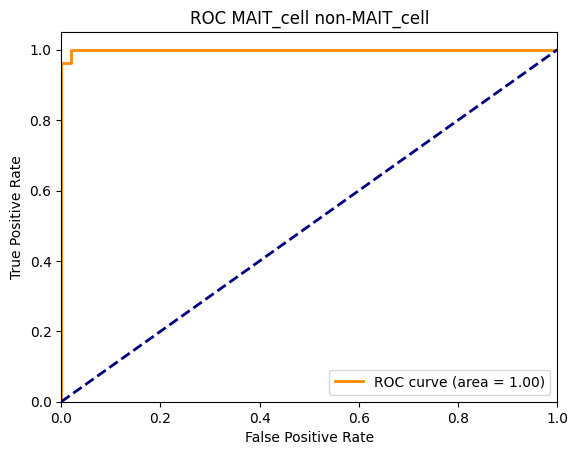

In [13]:
# get probabilities
probs = xgb_classifier.predict_proba(validation_embeddings)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(embed_validation_labels, probs[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# plot the roc curve for the model
figure_path = '/home/ubuntu/CRC_Project/CRC_blood/plots/MAIT_xgBoost_ROC.png'
plot_roc_curve(fpr_xgb, tpr_xgb, roc_auc_xgb, label_type_1, label_type_2, figure_path)


##### LDA

In [ ]:
from utils import lda_classify

In [47]:
# apply LDA
accuracy_lda, lda_preds, lda_classifier = lda_classify(train_embeddings,embed_train_labels, validation_embeddings, embed_validation_labels)
# plot the roc curve for the model
# get probabilities
probs = lda_classifier.predict_proba(validation_embeddings)
fpr_lda, tpr_lda, thresholds_lda = roc_curve(embed_validation_labels, probs[:, 1])
roc_auc_lda = auc(fpr_lda, tpr_lda)

accuracy_lda

97.11538461538461

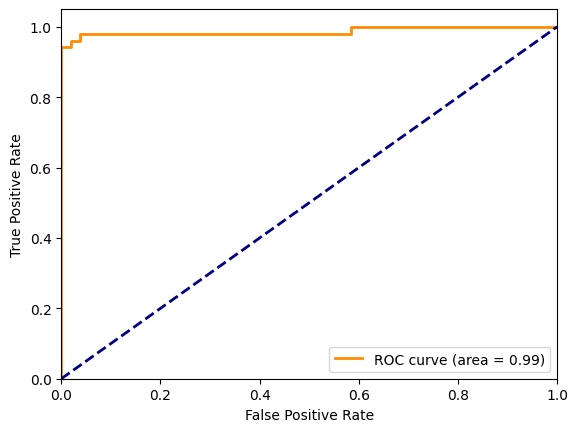

In [48]:
# plot the roc curve for the model
# get probabilities
probs = lda_classifier.predict_proba(validation_embeddings)
fpr_lda, tpr_lda, thresholds_lda = roc_curve(embed_validation_labels, probs[:, 1])
roc_auc_lda = auc(fpr_lda, tpr_lda)

figure_path_lda = '/home/ubuntu/CRC_Project/CRC_blood/plots/MAIT_LDA_ROC.png'
plot_roc_curve(fpr_lda, tpr_lda, roc_auc_lda, label_type_1, label_type_2, figure_path)